# PyGMT 練習帳

GMTをPythonから操作するモジュール．

## インストール

Anacondaの場合

```bash
$ conda install pygmt -c conda-forge
```

pipの場合

```bash
$ pip install pygmt
```

環境にGMTがインストールされていることも必要（たぶん）．

```{admonition} 注意書き
:class: tip
% 注意書き
ここにAdmonitionも書ける
```

## 準備：モジュールの読み込み

モジュール単独だけで，numpyやmatplotlibを別途importせずともちゃんと動作する．

In [1]:
import pygmt

データハンドリングのため，numpyも入れておく

In [3]:
import numpy as np

その他画像比較のための Image モジュールを利用

In [4]:
from IPython.display import Image

## pygmtによる作図の基本

作図の流れは

```
fig = pygmt.Figure()
```
で図のオブジェクトを作成し，GMTのコマンドに相当する
```
fig.XXXXX()
```
を重ねていくことで作図する．最後に
```
fig.show()
```
とすればJupyter上に表示されるし，
```
fig.savefig(filename)
```
とすると`filename`の拡張子に応じて画像として保存される．

## 基本の地図

`gmt pscoast` に相当する地図を作図してみる．

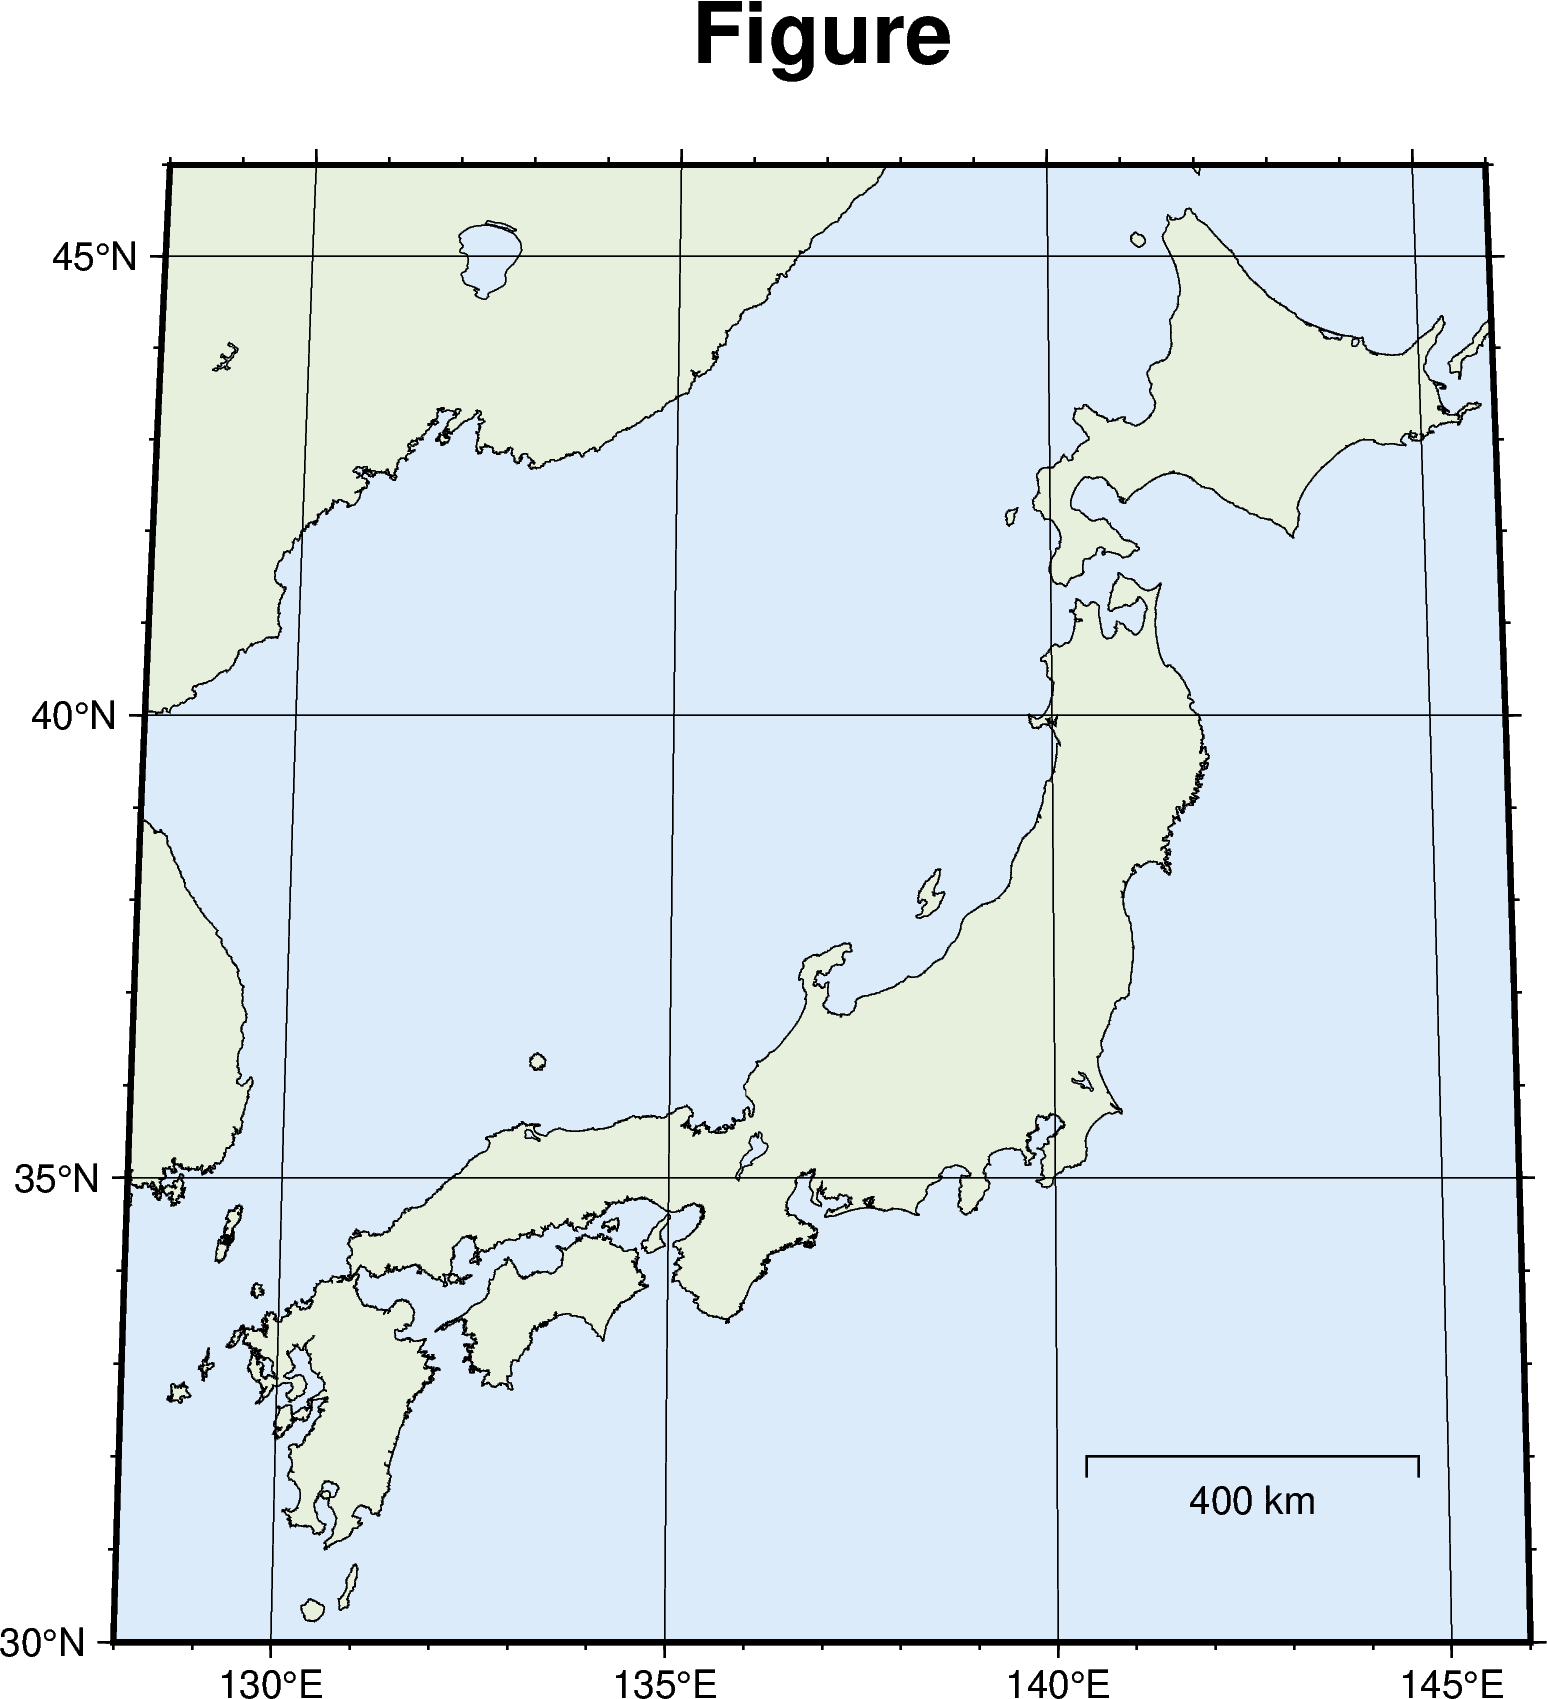

In [25]:
fig = pygmt.Figure()

fig.coast(
    projection  = 'N138/12c',                        # 投影法とサイズ．メルカトルなら 'M12c' など．
    region      = (128, 146, 30, 46),                # 領域はリストかタプルで与える．
    shorelines  = 'default,black',                   # 海岸線のペンの設定．
    area_thresh = 100,                               # 細かい領域の描画下限 (km^2)
    resolution  = 'f',                               # 'c', 'l', 'i', 'h', 'f' の順に高くなる
    land        = '230/240/220',                     # 陸地の色
    water       = '220/235/250',                     # 水の色
    map_scale   = '142.5/32/32/400',                 # 距離スケールの水平・縦位置と距離サイズ
    frame       = ['WSen+t"Figure"', 'xafg', 'yafg'] # 南西に軸名・タイトル指定（+t) およびXY方向それぞれの軸情報
)

fig.show()
fig.savefig('fig/pygmt-coastline.png')               # show=Trueオプションをつけるとビューワが開く


オプションはPythonシェル（IPythonやJupyter Notebookなど）で `help(fig.coast)` そすれば表示される．

上記の例では `fig.coast` ひとつですべてを描画したが，軸の描画を `fig.basemap` に任せることもできる：

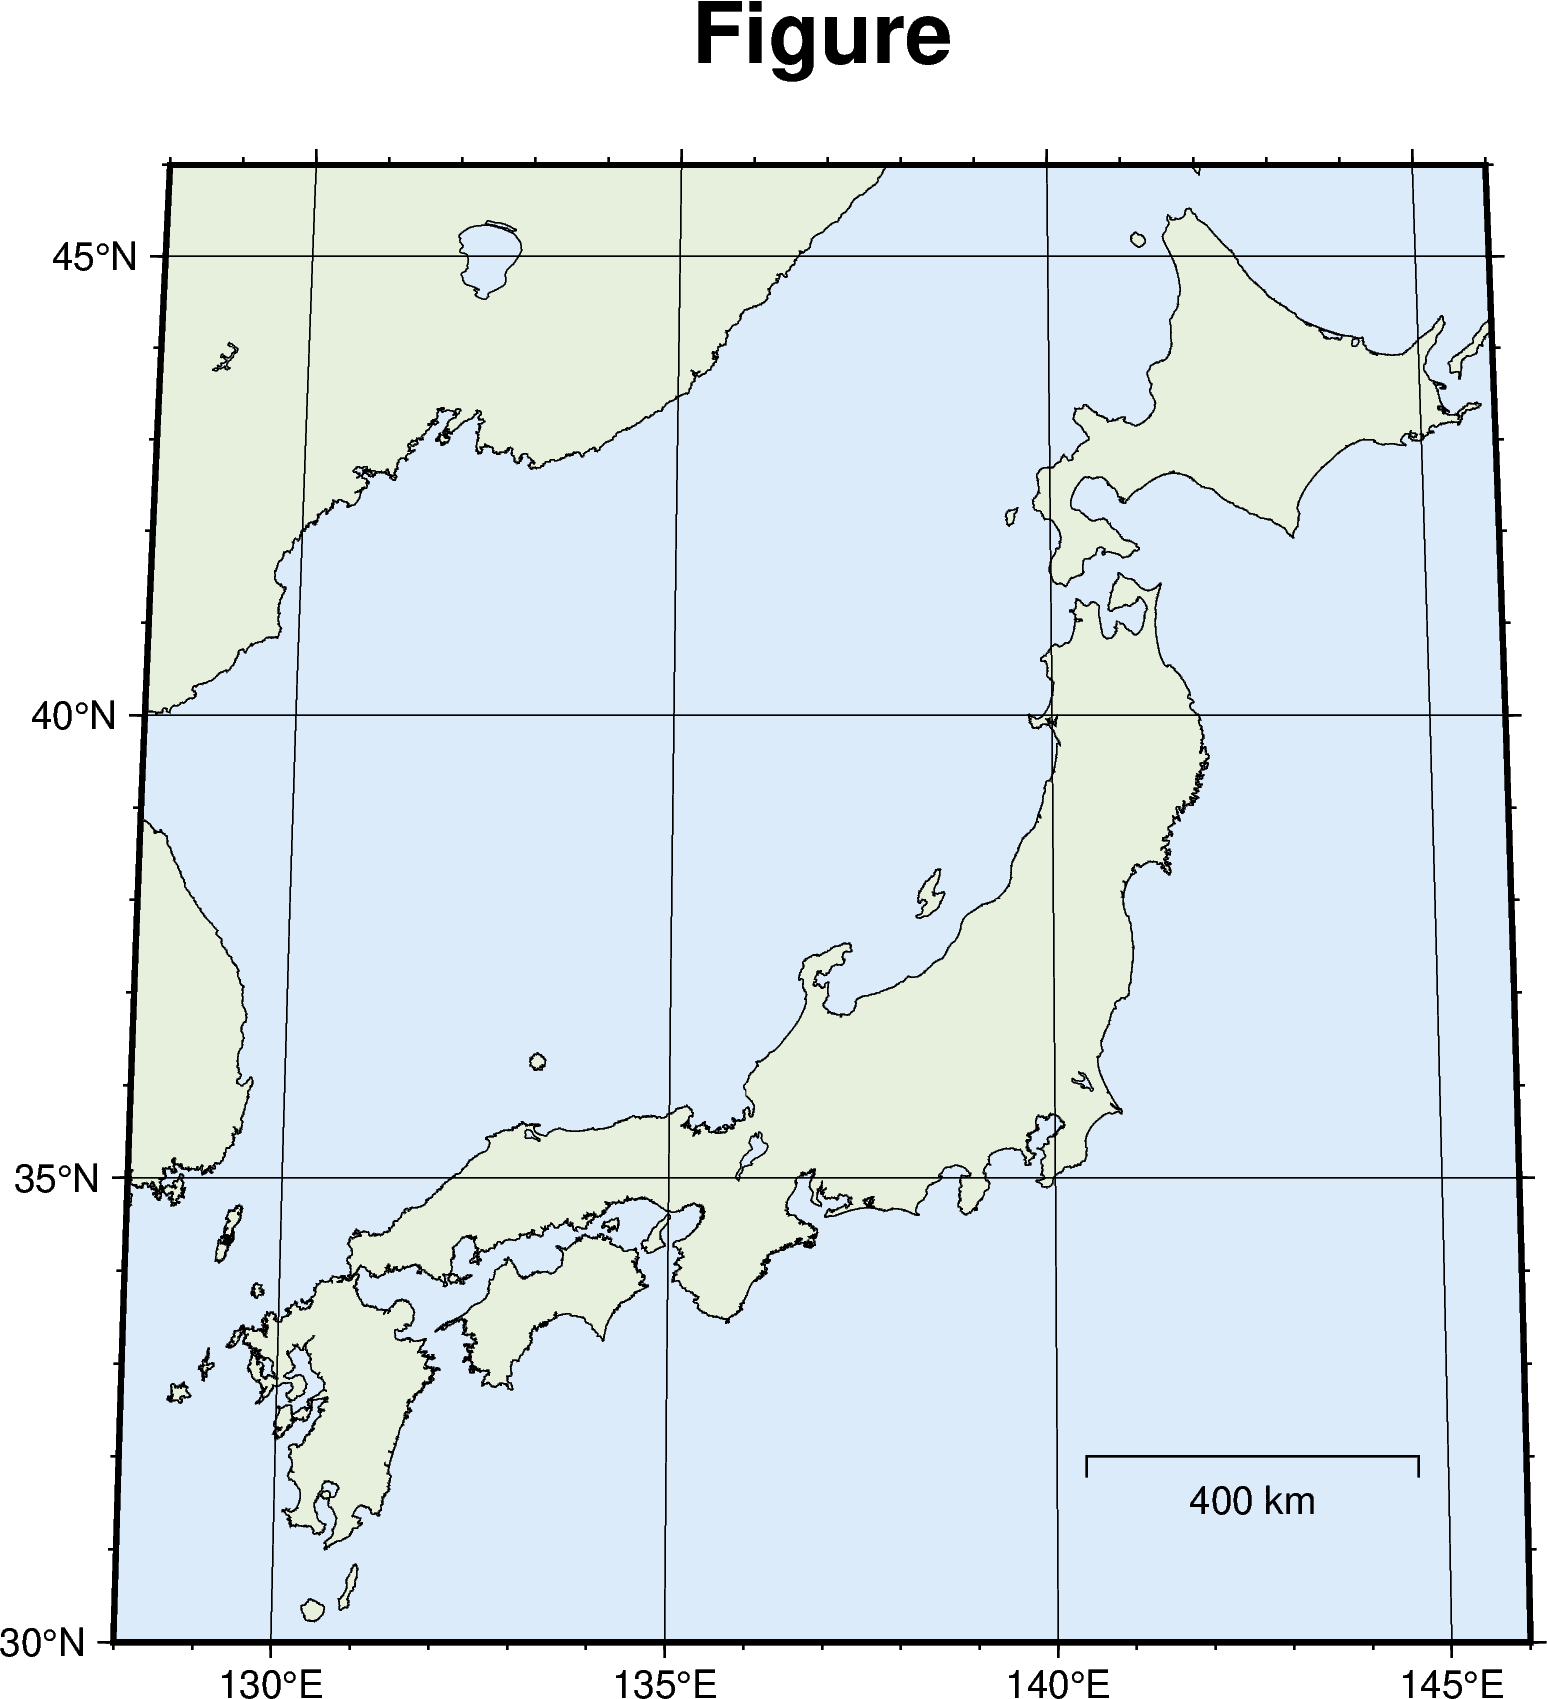

In [26]:
fig = pygmt.Figure()


fig.coast(
    projection  = 'N138/12c',          
    region      = (128, 146, 30, 46),  
    shorelines  = 'default,black',     
    area_thresh = 100,                 
    resolution  = 'f',                 
    land        = '230/240/220',       
    water       = '220/235/250',       
    map_scale   = '142.5/32/32/400',   
)

fig.basemap(
    frame       = ['WSen+t"Figure"', 'xafg', 'yafg'] 
)

fig.show()


### 従来型のGMTとの比較

同じ地図は，クラシックな GMT `bash` シェルスクリプトによって以下のように作図される．
次の入力にある `%%bash` は **bash magic** と呼ばれるもので，Jupyter Notebookでbashを実行するもの．同じセル内に書かれたものは `bash` により実行される．

In [27]:
%%bash

# 海岸線と枠を描画
gmt pscoast -JN138/12c -R128/146/30/46 -Wdefault,black -A100 -Df \
    -G230/240/220 -S220/235/250 -L142.5/32/32/400 -BWSen+t"Figure" -Bxafg -Byafg \
    > fig/classic-coastline.ps

# Postscript画像をPNGに変換
gmt psconvert -Tg -A -P -Qg2 -Qt2 fig/classic-coastline.ps

# 不要な中間生成物であるPostscriptを削除
rm -f fig/classic-coastline.ps

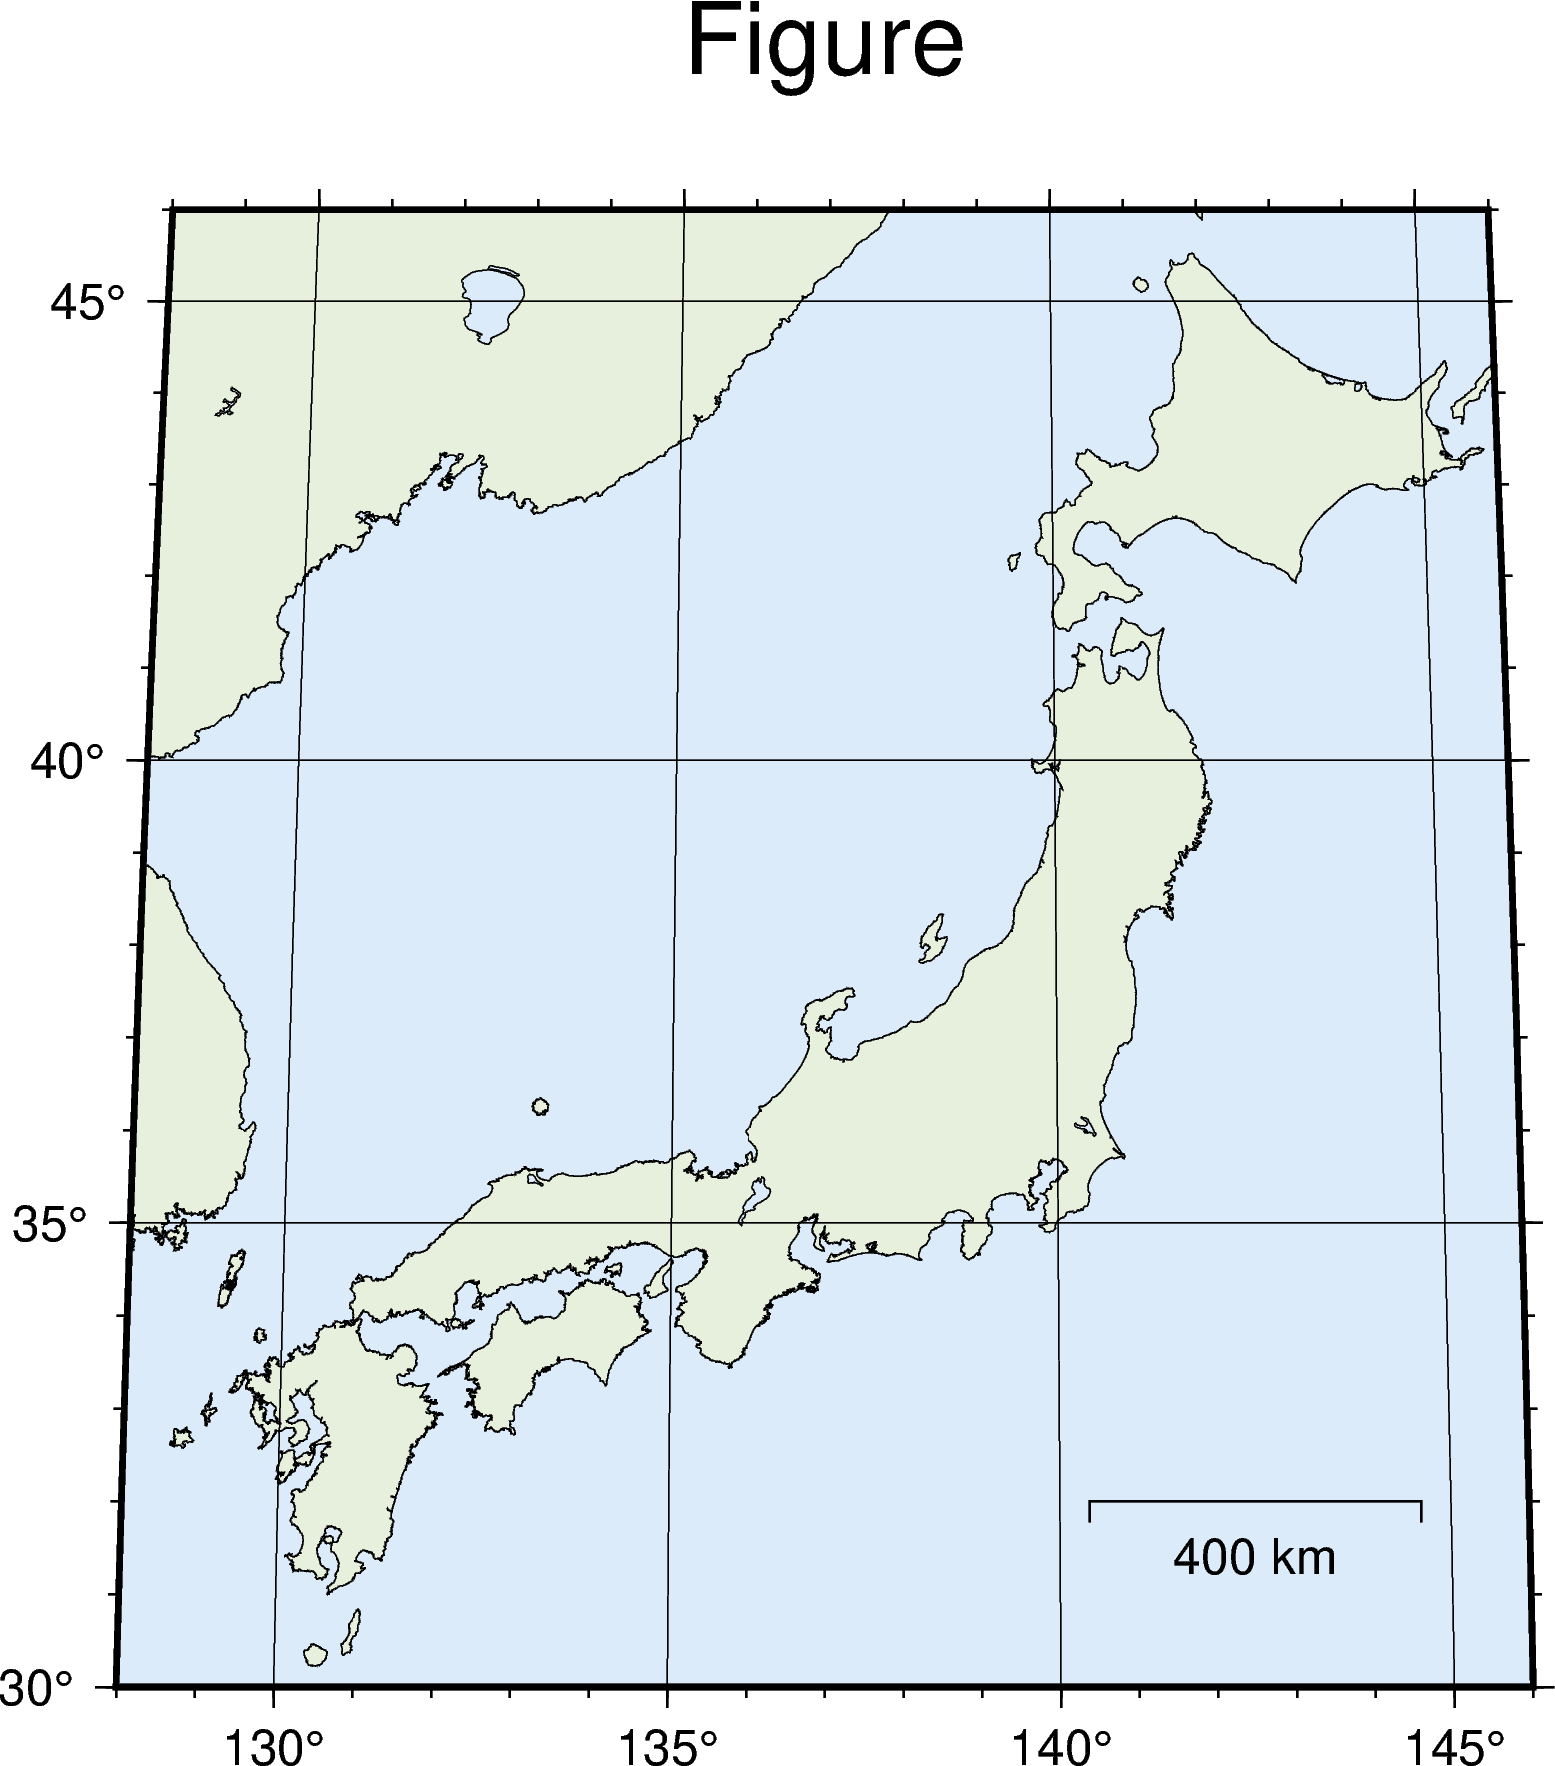

In [28]:
Image('fig/classic-coastline.png', width="60%")

ほぼ同じ画像が生成されたが，フォントサイズや緯度経度の単位（degree-E/degree-N）の有無，タイトルのフォントなどが微妙に異なる．これらは `gmt default` コマンドで調整可能なものである．

ちなみにGMT6の新しいmodern modeを使うと以下のようにも書ける．

In [29]:
%%bash

gmt begin fig/modern-coastline png
    gmt coast \
        -JN138/12c -R128/146/30/46 -Wdefault,black -A100 -Df \
        -G230/240/220 -S220/235/250 -L142.5/32/32/400 \
        -BWSen+t"Figure" -Bxafg -Byafg 
gmt end

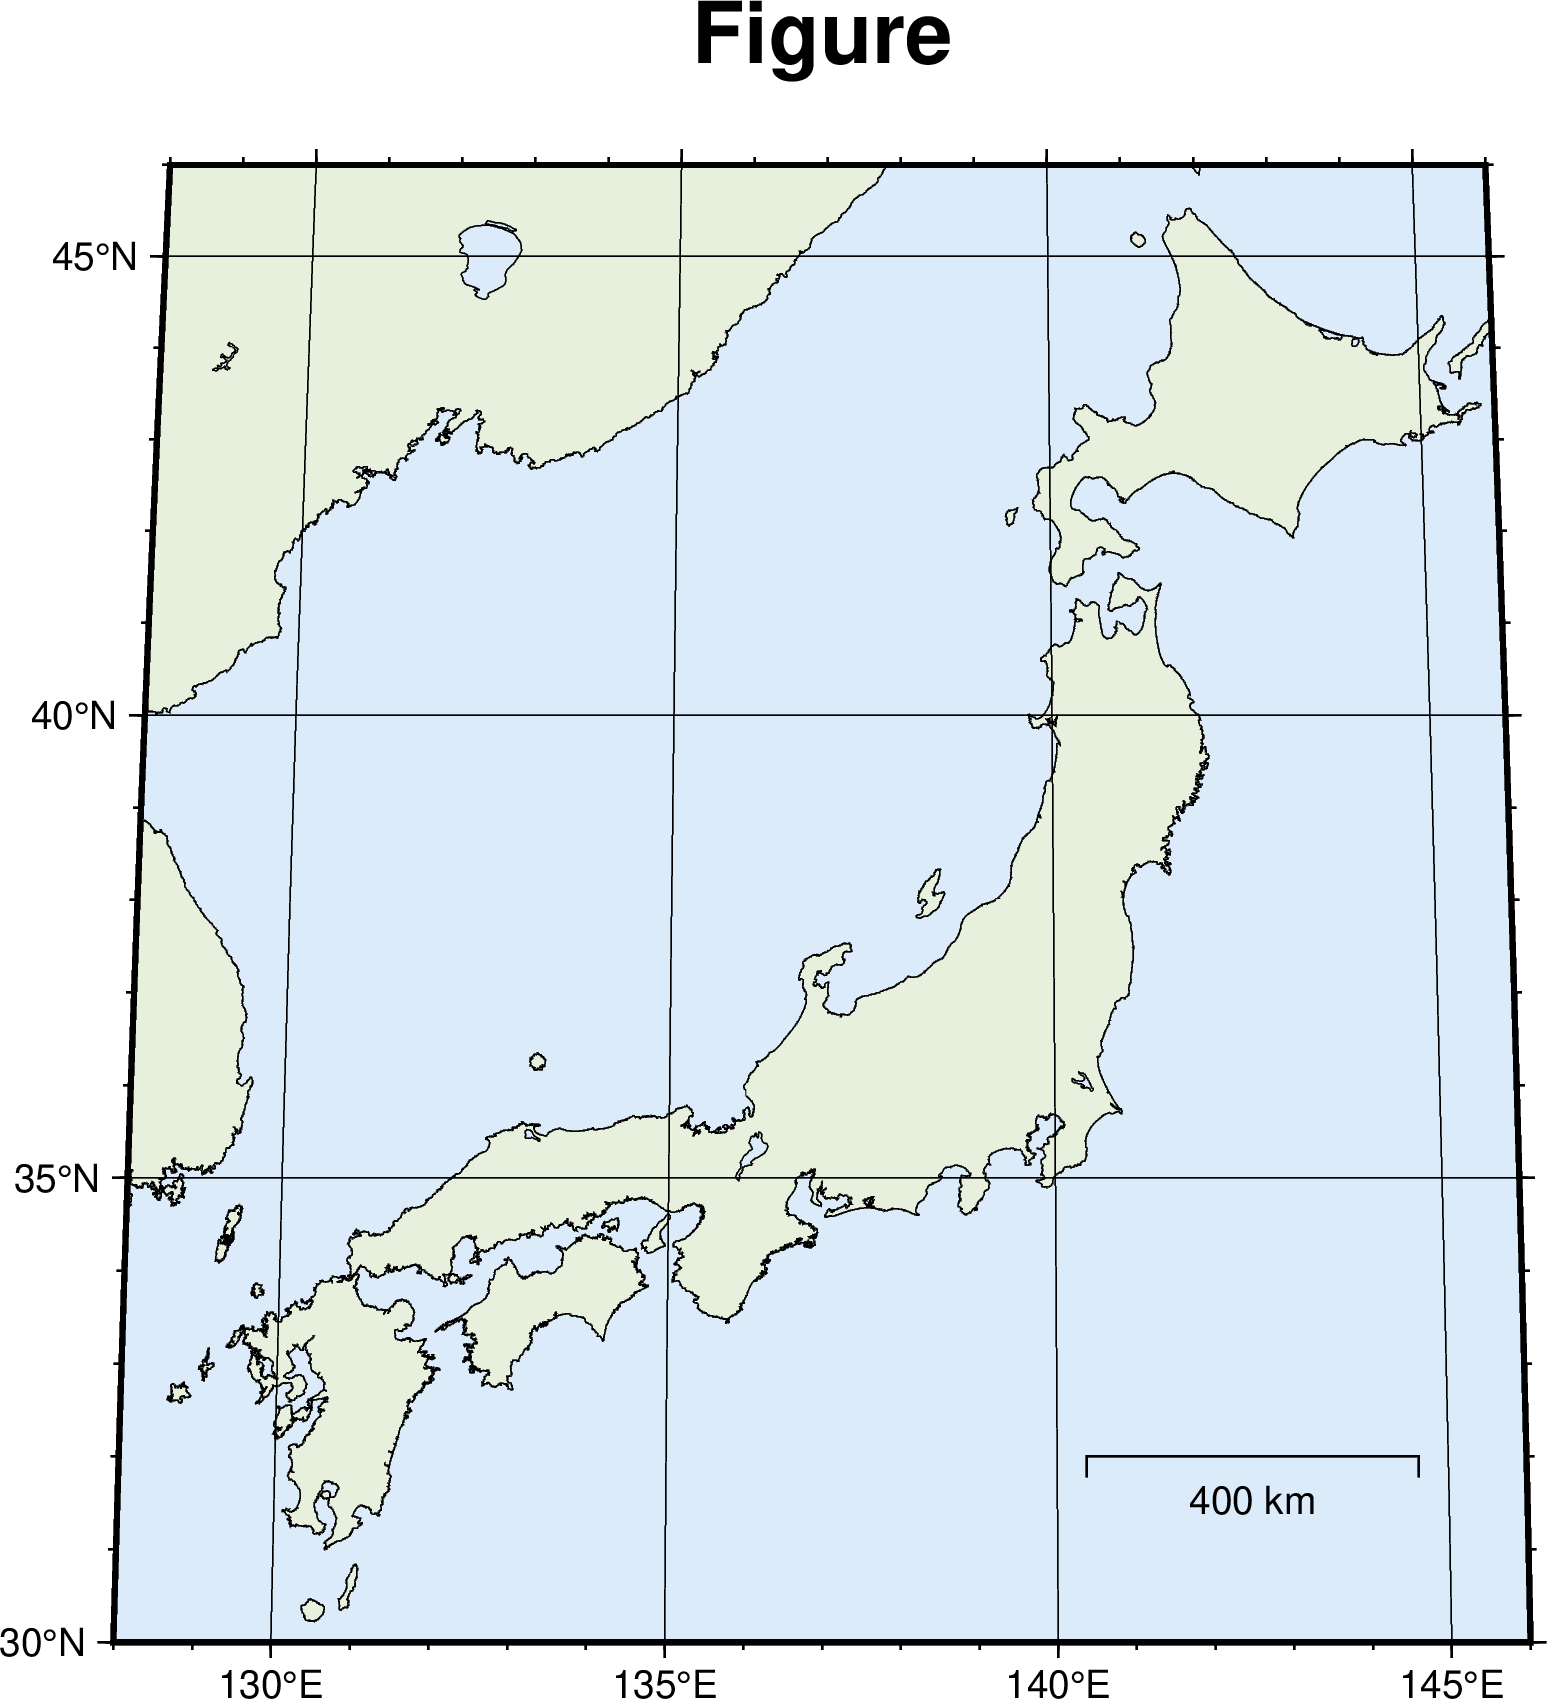

In [30]:
Image('fig/modern-coastline.png', width="60%")

こちらは `pygmt` とほぼ完全に同じ絵が出力された．`pygmt` はGMT modern modeのラッパーとして動作しているものと想像される．

それぞれのモードを独断と偏見で比較すると…

- `pygmt` ではコマンドに与えるオプションの名前がより直感的になった．しかし，逆に従来のGMTユーザーからはそのオプションの名前を調べる必要が出てくる．ドキュメントがどれだけ充実しているかは要調査．
- `pygmt` はPythonと透過的に使えるため，Python上のデータを直接プロットするのに向いている．
- `GMT modern mode` は従来のGMTの面倒な `-O` `-K` オプションなどを廃して比較的楽にスクリプトが書ける．GMTの挙動をどれだけ細かく制御できるかどうかは未調査．
- `GMT classic` は完全なシェルコマンドとして動作するので，複雑なシェルスクリプトの中で動作させるのに向いている（かもしれない）．

## 地図上への情報描画

pygmtが用意しているexampleデータに日本列島周辺の地震があるのでそれを用いる．pandasのデータフレームとして地震の情報がロードされる．
しかし，pandasの利用法を意識する必要はなく，単にリストとして緯度・軽度などのデータを用いるだけである．

In [37]:
data = pygmt.datasets.load_japan_quakes()
print(data)

     year  month  day  latitude  longitude  depth_km  magnitude
0    1987      1    4     49.77     149.29       489        4.1
1    1987      1    9     39.90     141.68        67        6.8
2    1987      1    9     39.82     141.64        84        4.0
3    1987      1   14     42.56     142.85       102        6.5
4    1987      1   16     42.79     145.10        54        5.1
..    ...    ...  ...       ...        ...       ...        ...
110  1988     11   10     35.32     140.88        10        4.0
111  1988     11   29     35.88     141.47        46        4.0
112  1988     12    3     43.53     146.98        39        4.3
113  1988     12   20     43.94     146.13       114        4.5
114  1988     12   21     42.02     142.45        73        4.5

[115 rows x 7 columns]


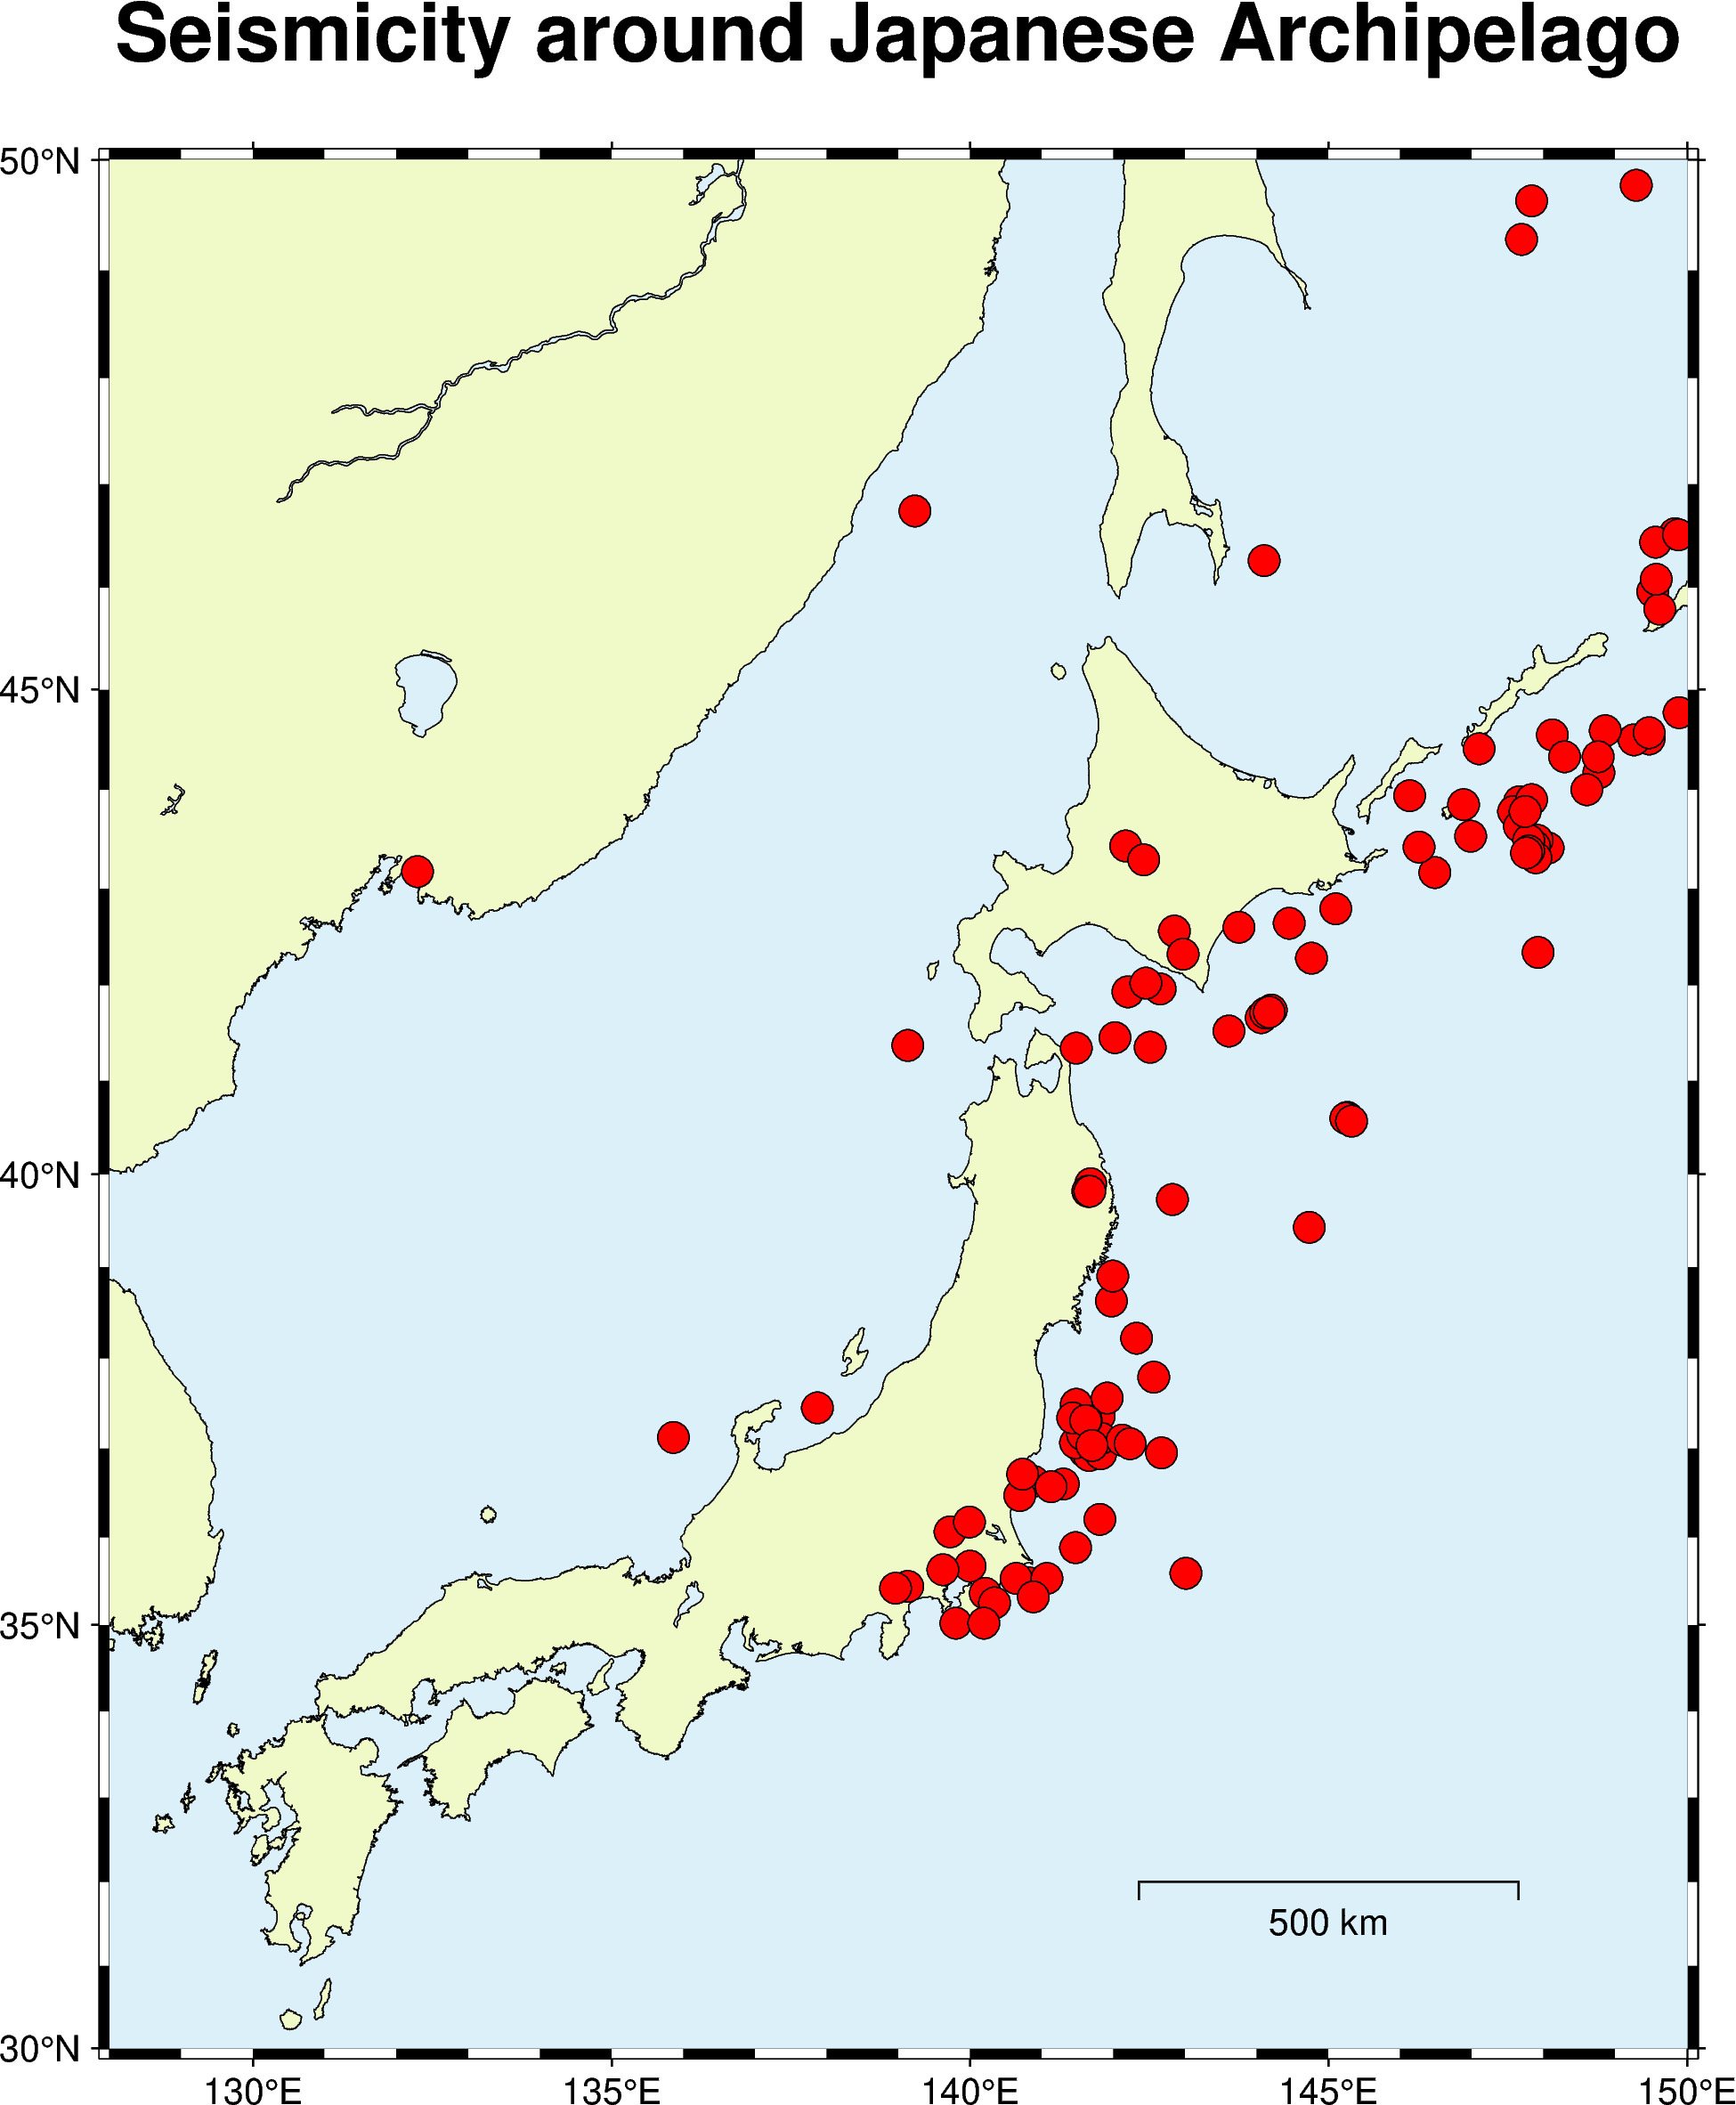

In [56]:
fig = pygmt.Figure()

fig.basemap(
    region = [128,150,30, 50],
    projection = 'M15c', 
    frame = ['WSen+t"Seismicity around Japanese Archipelago"', 'xaf', 'yaf'],
)

fig.coast(
    land        = '240/250/200', 
    water       = '220/240/250', 
    resolution  = 'h', 
    area_thresh = '100', 
    map_scale   = '145/32/32/500',
    shorelines  = 'default,black'
)

pygmt.makecpt(cmap = 'viridis', series=[0., 700.])

fig.plot(
    x = data.longitude,
    y = data.latitude,
    color = 'red', 
    style = 'c0.3c', 
    pen = 'black'
)

fig.show()


## GRDデータの扱い

To be available soon ... ?

## グラフの微調整

## Obspyとの連携

To be available someday, probably ...